In [68]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt

#numpy配列を省略しないようにする
np.set_printoptions(threshold=np.inf)
#pandasを省略しないようにする
pd.set_option('display.max_columns', 500) # 列
pd.set_option('display.max_rows', 500)  # 行

mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード

In [69]:
# 正規化関数
def mmscaler(data):
    mm = preprocessing.MinMaxScaler()  # 正規化エンコード、デコード
    dat = mm.fit_transform(data)
    return dat

# 目的変数の作成関数 1:df 2:目的変数のカラム名称 3:shiftさせるカラム名称 4:shiftする数
def shift(df, t_name, t_column, shift):
    df[t_name] = df[t_column].shift(shift) # 1行上にずらして5分後の値にしている
    return df

In [70]:
# トレーニングデータの作成
def create_data(read_dir, save_dir):
    df = pd.read_csv(read_dir, encoding='shift_jis')
    #カラムを削除
    df = df.dropna()  # NaNを削除
    #df.drop(labels='日付(ローソク足)', axis=1, inplace=True) # ろうそく足データの日付
    
    df['time'] = pd.to_datetime(df['time']  )#, format='%Y-%m-%d-%A %H:%M:%S')  # 日付カラムを日付型に変換
    df['time(hour)'] = df['time'].dt.hour  # hourをデータに追加
    df['time(minute)'] = df['time'].dt.minute  # minuteをデータに追加
    df['time(weekday)'] = df['time'].dt.dayofweek  # minuteをデータに追加
    # df['日付']カラムが [datetime64[ns]]型になっていて扱いづらいので最後に削除する
    #df.drop(labels='日付', axis=1, inplace=True)
    
    date = df['time'] # 代入して変数を避難させる
    
    
    shift(df, 'y_rate_1h', 'close', -1)  # 目的変数の作成関数
    shift(df, 'y_rate_2h', 'close', -2)  # 目的変数の作成関数
    shift(df, 'y_rate_3h', 'close', -3)  # 目的変数の作成関数
    shift(df, 'y_rate_4h', 'close', -4)  # 目的変数の作成関数
    shift(df, 'y_rate_5h', 'close', -5)  # 目的変数の作成関数
    shift(df, 'y_rate_6h', 'close', -6)  # 目的変数の作成関数
    shift(df, 'y_rate_7h', 'close', -7)  # 目的変数の作成関数
    shift(df, 'y_rate_8h', 'close', -8)  # 目的変数の作成関数
    shift(df, 'y_rate_9h', 'close', -9)  # 目的変数の作成関数
    shift(df, 'y_rate_10h', 'close', -10)  # 目的変数の作成関数
    shift(df, 'y_rate_11h', 'close', -11)  # 目的変数の作成関数
    shift(df, 'y_rate_12h', 'close', -12)  # 目的変数の作成関数
    shift(df, 'y_rate_13h', 'close', -13)  # 目的変数の作成関数
    shift(df, 'y_rate_14h', 'close', -14)  # 目的変数の作成関数
    shift(df, 'y_rate_15h', 'close', -15)  # 目的変数の作成関数
    shift(df, 'y_rate_16h', 'close', -16)  # 目的変数の作成関数
    shift(df, 'y_rate_17h', 'close', -17)  # 目的変数の作成関数
    shift(df, 'y_rate_18h', 'close', -18)  # 目的変数の作成関数
    shift(df, 'y_rate_19h', 'close', -19)  # 目的変数の作成関数
    shift(df, 'y_rate_20h', 'close', -20)  # 目的変数の作成関数
    shift(df, 'y_rate_21h', 'close', -21)  # 目的変数の作成関数
    shift(df, 'y_rate_22h', 'close', -22)  # 目的変数の作成関数
    shift(df, 'y_rate_23h', 'close', -23)  # 目的変数の作成関数
    shift(df, 'y_rate_24h', 'close', -24)  # 目的変数の作成関数

    
    df = df.dropna()  # NaNを削除
    #df = df.loc[:, '2':'time(weekday)'].astype('float32')  # データ型をfloatに変換して代入
    #df.insert(0, 'time(week)', date)  # 日付を1列目に代入
    #df.to_csv(save_dir , encoding='shift_jis', index=False)
    return df

In [71]:
# 変数宣言
read_dir = "./shape/1.csv"
save_dir =  "./model/after.csv"


after = -1 # shift関数のスライド数 (1行上にずらして-分後の値にしている)
name = '4h'
t_column = 'close'  # 目的変数のカラム
t_name = 'y_rate_5m'


In [72]:
# ***************************************トレーニングデータの作成***************************************
df = create_data(read_dir, save_dir)
df.to_csv("./model/中間ファイル.csv", encoding='shift_jis', index=False)
# ***************************************トレーニングデータの作成***************************************




In [73]:
def model_create():
    #n_inputs = len(X_train.columns)  # 入力数
    model = keras.models.Sequential()
   # model.add(keras.layers.Dense(1200, activation='sigmoid'))
   # model.add(keras.layers.Dense(300, activation='sigmoid'))
   # model.add(keras.layers.Dense(6, activation='linear'))
    model.add(keras.layers.LSTM(1, activation='linear',
                  #recurrent_activation='sigmoid',
                  kernel_initializer='glorot_normal',
                   recurrent_initializer='orthogonal',
                               batch_input_shape=(None, n_inputs, 1)))
    #model.add(keras.layers.Dense(1200, activation='linear'))
    #model.add(keras.layers.Dense(100, activation='linear'))
    #model.add(keras.layers.Dense(50, activation='linear'))
    #model.add(keras.layers.Dense(7, activation='linear'))
    #model.add(keras.layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(lr=0.1)  # オプティマイザ
    loss_fn = keras.losses.mse  # 損失関数
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=['mae'])  # コンパイル
    #model.summary()
    return model

In [74]:
# 入力したインプットデータを正規化、形状を整える関数
def create_traindata(df, X_train, y_train):

    print('入力数:', X_train.columns)
    row_count = len(y_train)  # 行数を取得(形状の作成に使用)
    column_count = len(X_train.columns)  # 列数を取得(形状の作成に使用)
    
    print('行数:', row_count)
    print('列数:', column_count)
    print('整形前の形状(特徴量):', X_train.shape)
    X_train = mm.fit_transform(X_train)  # 正規化
    X_train = np.array(X_train).reshape(row_count, column_count, -1)  # 特徴量の形状(3次元)
    y_train = np.array(y_train).reshape(row_count,1)  # 特徴量の形状
    y_train = mm.fit_transform(y_train)  # 正規化

    print('形状(特徴量):', X_train.shape)
    print('形状(目的変数):', y_train.shape)
    return X_train, y_train

In [75]:
# モデルの学習関数
def learn_model(X_train, y_train, model_name, param_name, epochs):
    model = model_create()  # モデル作成
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
    
    # 学習 LSTM_GBPJPY
    print('モデルの学習を開始します')
    history_model = model.fit(X_train, y_train, batch_size=1,epochs=epochs,validation_split=0.05,
                                                  callbacks=[
                                                  #tensorboard,
                                                  earlystopping
                                                  ])
    
    model.save(model_name)  # モデルを保存
    model.save_weights(param_name)  # 重みを保存
    return model

In [76]:
# 予測関数
def predict(model, X_train, y_train):
    y_pred_one = model(X_train[-2:-1])  # 最終行の予測
    y_pred = model(X_train)
    y_pred_one = mm.inverse_transform(y_pred_one)  # 予測結果の正規化をデコード
    y_pred = mm.inverse_transform(y_pred)  # 予測結果の正規化をデコード
    y_train = mm.inverse_transform(y_train)  # 実際の結果の正規化をデコード
    return y_pred_one, y_pred, y_train

In [77]:
# プロット関数
def plot_result(y_pred, y_train, title):
    flg = plt.figure()
    fig = plt.figure(figsize=(6, 4), dpi=72, linewidth=10)
    ax = fig.add_subplot(111, xlabel='number', ylabel='price',title=title)  # グラフ作成
    
    ax.plot(y_train, label='actual')  # 実測
    ax.plot(y_pred, label='predict')  # 予測
    
    plt.legend()

In [78]:
# 学習関数
def learn(df, X_train, y_rate, title, epochs, model_dir, param_dir):
    #**********1時間後予測**********学習のinput情報(特徴量、答え)
    y_train = df.loc[:, y_rate]  # 全行 , 最終列
    X_train, y_train = create_traindata(df, X_train, y_train)  # 入力したインプットデータをdropna、正規化、形状を整える
    model = learn_model(X_train, y_train, model_dir, param_dir, epochs)  # モデルの学習
    y_pred_one, y_pred, y_train = predict(model, X_train, y_train) # 予測
    #y_train = df.loc[:, y_rate]  # y_trainを代入しなおす
    plot_result(y_pred, y_train, title)  # プロット
   # y_pred = model(X_train.iloc[-1])
    return y_pred_one, y_pred

In [79]:
# X_trainデータ作成
df = df.dropna()  # Nanを削除
X_train = df.loc[:, 'open':'time(weekday)']  # 全行 , 列名称(始まり):列名称(終わり)
n_inputs = len(X_train.columns)  # 入力数
#X_train[-2:-1]

In [80]:
#model = keras.models.load_model('model.hdf5')  # モデルを読込み
#model.load_weights('param.hdf5')  # 重みを読込み

In [81]:
#model.save('model.hdf5')  # モデルを保存
#model.save_weights('param.hdf5')  # 重みを保存

In [82]:
"""廃止
# n時間後の時刻とレートを計算してdfに反映関数
def UNIX_RATE_conversion(df, time, name):
    # UNIX時間に変更
    df['日付UNIX'] = pd.to_datetime(df['日付']).dt.tz_localize('Asia/Tokyo')
    df['日付UNIX'] = df['日付UNIX'].astype('int64') // 10**9
    
    df['日付UNIX' + name] = df['日付UNIX'].shift(time) # 1行上にずらして5分後の値にしている
    df['日付UNIX_計算後' + name] = df['日付UNIX' + name] - df['日付UNIX'] # -分後の値か表した変数
    df['RATE' + name] = df['bid_close'].shift(time)

    return df  # n分後のUNIX時間、レートの計算結果を反映している

"""



"廃止\n# n時間後の時刻とレートを計算してdfに反映関数\ndef UNIX_RATE_conversion(df, time, name):\n    # UNIX時間に変更\n    df['日付UNIX'] = pd.to_datetime(df['日付']).dt.tz_localize('Asia/Tokyo')\n    df['日付UNIX'] = df['日付UNIX'].astype('int64') // 10**9\n    \n    df['日付UNIX' + name] = df['日付UNIX'].shift(time) # 1行上にずらして5分後の値にしている\n    df['日付UNIX_計算後' + name] = df['日付UNIX' + name] - df['日付UNIX'] # -分後の値か表した変数\n    df['RATE' + name] = df['bid_close'].shift(time)\n\n    return df  # n分後のUNIX時間、レートの計算結果を反映している\n\n"

入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0545 - mae: 0.1720 - val_loss: 0.0065 - val_mae: 0.0677
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0176 - mae: 0.1054 - val_loss: 0.0320 - val_mae: 0.1695
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0145 - mae: 0.0946 - val_loss: 0.0229 - val_mae: 0.1409
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0163 - mae: 0.0895 - val_loss: 0.0015 - val_mae: 0.0322
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

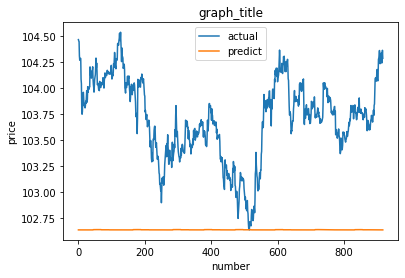

In [83]:
epochs = 15
graph_title = '1h'
y_pred_1h, y_pred = learn(df, X_train, 'y_rate_1h', 'graph_title', epochs, './model/GBPJPY_1h/model.hdf5','./model/GBPJPY_1h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0591 - mae: 0.1940 - val_loss: 0.0505 - val_mae: 0.1779
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0434 - mae: 0.1653 - val_loss: 0.0491 - val_mae: 0.1755
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0430 - mae: 0.1675 - val_loss: 0.0495 - val_mae: 0.1765
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0409 - mae: 0.1616 - val_loss: 0.0322 - val_mae: 0.1500
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

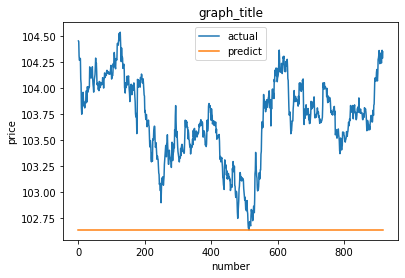

In [84]:
epochs = 15
graph_title = '2h'
y_pred_2h, y_pred = learn(df, X_train, 'y_rate_2h', 'graph_title', epochs, './model/GBPJPY_2h/model.hdf5','./model/GBPJPY_2h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0561 - mae: 0.1916 - val_loss: 0.0395 - val_mae: 0.1660
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0448 - mae: 0.1717 - val_loss: 0.0608 - val_mae: 0.2012
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0445 - mae: 0.1725 - val_loss: 0.0663 - val_mae: 0.2145
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0445 - mae: 0.1726 - val_loss: 0.0376 - val_mae: 0.1599
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

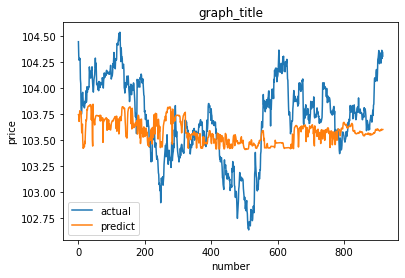

In [85]:
epochs = 15
graph_title = '3h'
y_pred_3h, y_pred = learn(df, X_train, 'y_rate_3h', 'graph_title', epochs, './model/GBPJPY_3h/model.hdf5','./model/GBPJPY_3h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0642 - mae: 0.1988 - val_loss: 0.0723 - val_mae: 0.2238
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0468 - mae: 0.1746 - val_loss: 0.0620 - val_mae: 0.2050
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0441 - mae: 0.1692 - val_loss: 0.0509 - val_mae: 0.1834
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0392 - mae: 0.1569 - val_loss: 0.0686 - val_mae: 0.2209
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

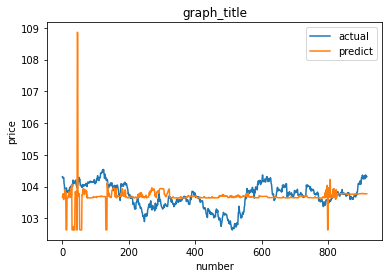

In [86]:
epochs = 15
graph_title = '4h'
y_pred_4h, y_pred = learn(df, X_train, 'y_rate_4h', 'graph_title', epochs, './model/GBPJPY_4h/model.hdf5','./model/GBPJPY_4h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0575 - mae: 0.1961 - val_loss: 0.0192 - val_mae: 0.1304
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0424 - mae: 0.1675 - val_loss: 0.0443 - val_mae: 0.1738
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0412 - mae: 0.1624 - val_loss: 0.0451 - val_mae: 0.1762
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0435 - mae: 0.1678 - val_loss: 0.0456 - val_mae: 0.1764
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

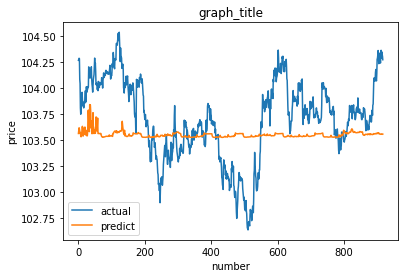

In [87]:
epochs = 15
graph_title = '5h'
y_pred_5h, y_pred = learn(df, X_train, 'y_rate_5h', 'graph_title', epochs, './model/GBPJPY_5h/model.hdf5','./model/GBPJPY_5h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0793 - mae: 0.2213 - val_loss: 0.1029 - val_mae: 0.2784
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0489 - mae: 0.1755 - val_loss: 0.0791 - val_mae: 0.2482
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0501 - mae: 0.1780 - val_loss: 0.1249 - val_mae: 0.3165
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0480 - mae: 0.1767 - val_loss: 0.0741 - val_mae: 0.2339
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

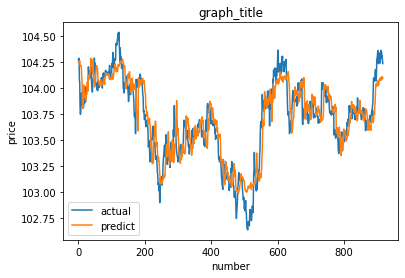

In [88]:
epochs = 15
graph_title = '6h'
y_pred_6h, y_pred = learn(df, X_train, 'y_rate_6h', 'graph_title', epochs, './model/GBPJPY_6h/model.hdf5','./model/GBPJPY_6h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.3298 - mae: 0.4998 - val_loss: 0.0621 - val_mae: 0.2086
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0430 - mae: 0.1673 - val_loss: 0.0459 - val_mae: 0.1786
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0458 - mae: 0.1735 - val_loss: 0.0563 - val_mae: 0.1997
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0419 - mae: 0.1653 - val_loss: 0.0326 - val_mae: 0.1567
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

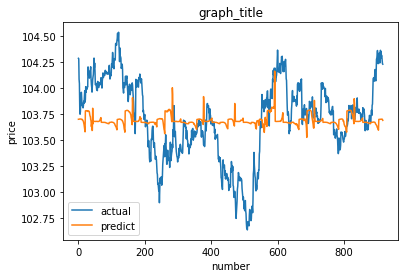

In [89]:
epochs = 15
graph_title = '7h'
y_pred_7h, y_pred = learn(df, X_train, 'y_rate_7h', 'graph_title', epochs, './model/GBPJPY_7h/model.hdf5','./model/GBPJPY_1h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0636 - mae: 0.1964 - val_loss: 0.0530 - val_mae: 0.1958
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0400 - mae: 0.1592 - val_loss: 0.1070 - val_mae: 0.2995
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0409 - mae: 0.1626 - val_loss: 0.1007 - val_mae: 0.2897
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0416 - mae: 0.1647 - val_loss: 0.0779 - val_mae: 0.2491
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

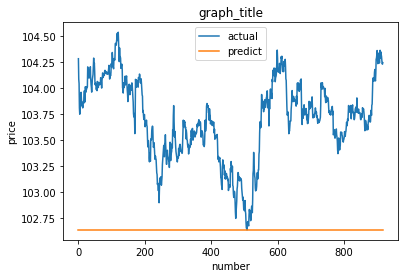

In [90]:
epochs = 15
graph_title = '8h'
y_pred_8h, y_pred = learn(df, X_train, 'y_rate_8h', 'graph_title', epochs, './model/GBPJPY_8h/model.hdf5','./model/GBPJPY_8h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0673 - mae: 0.2024 - val_loss: 0.0629 - val_mae: 0.2177
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0396 - mae: 0.1602 - val_loss: 0.0665 - val_mae: 0.2263
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0424 - mae: 0.1663 - val_loss: 0.2080 - val_mae: 0.4404
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0430 - mae: 0.1673 - val_loss: 0.0810 - val_mae: 0.2584
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

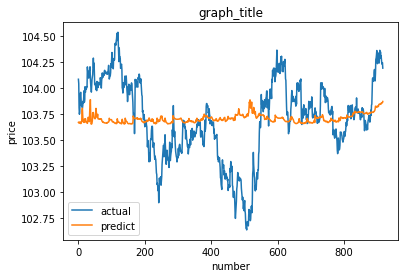

In [91]:
epochs = 15
graph_title = '9h'
y_pred_9h, y_pred = learn(df, X_train, 'y_rate_9h', 'graph_title', epochs, './model/GBPJPY_9h/model.hdf5','./model/GBPJPY_9h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0680 - mae: 0.1996 - val_loss: 0.0629 - val_mae: 0.2190
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0435 - mae: 0.1648 - val_loss: 0.0490 - val_mae: 0.1923
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0432 - mae: 0.1690 - val_loss: 0.0900 - val_mae: 0.2732
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0400 - mae: 0.1599 - val_loss: 0.0469 - val_mae: 0.1861
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

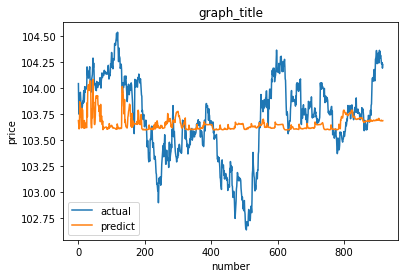

In [92]:
epochs = 15
graph_title = '10h'
y_pred_10h, y_pred = learn(df, X_train, 'y_rate_10h', 'graph_title', epochs, './model/GBPJPY_10h/model.hdf5','./model/GBPJPY_10h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0668 - mae: 0.2032 - val_loss: 0.0573 - val_mae: 0.2148
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0441 - mae: 0.1650 - val_loss: 0.0635 - val_mae: 0.2289
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0434 - mae: 0.1682 - val_loss: 0.0441 - val_mae: 0.1849
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0436 - mae: 0.1672 - val_loss: 0.0645 - val_mae: 0.2245
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

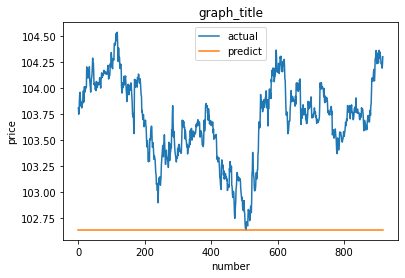

In [93]:
epochs = 15
graph_title = '11h'
y_pred_11h, y_pred = learn(df, X_train, 'y_rate_11h', 'graph_title', epochs, './model/GBPJPY_11h/model.hdf5','./model/GBPJPY_11h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0529 - mae: 0.1828 - val_loss: 0.0540 - val_mae: 0.2063
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0439 - mae: 0.1701 - val_loss: 0.0733 - val_mae: 0.2450
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0422 - mae: 0.1645 - val_loss: 0.0817 - val_mae: 0.2620
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0397 - mae: 0.1596 - val_loss: 0.0800 - val_mae: 0.2585
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

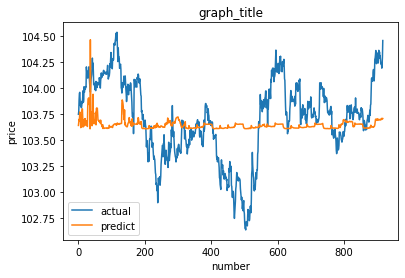

In [94]:
epochs = 15
graph_title = '12h'
y_pred_12h, y_pred = learn(df, X_train, 'y_rate_12h', 'graph_title', epochs, './model/GBPJPY_12h/model.hdf5','./model/GBPJPY_12h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 22.8628 - mae: 0.9990 - val_loss: 0.7840 - val_mae: 0.8776
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.4357 - mae: 0.6271 - val_loss: 0.7782 - val_mae: 0.8743
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.4350 - mae: 0.6284 - val_loss: 0.7691 - val_mae: 0.8691
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.4318 - mae: 0.6243 - val_loss: 0.7565 - val_mae: 0.8618
Epoch 5/15
872/872 [===================

<Figure size 432x288 with 0 Axes>

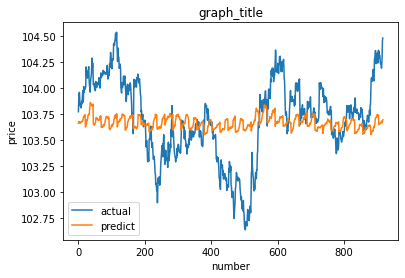

In [95]:
epochs = 15
graph_title = '13h'
y_pred_13h, y_pred = learn(df, X_train, 'y_rate_13h', 'graph_title', epochs, './model/GBPJPY_13h/model.hdf5','./model/GBPJPY_13h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0761 - mae: 0.2171 - val_loss: 0.0604 - val_mae: 0.2206
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0433 - mae: 0.1657 - val_loss: 0.0734 - val_mae: 0.2470
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0399 - mae: 0.1584 - val_loss: 0.0756 - val_mae: 0.2514
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0401 - mae: 0.1592 - val_loss: 0.0693 - val_mae: 0.2374
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

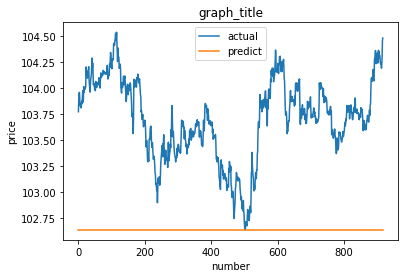

In [96]:
epochs = 15
graph_title = '14h'
y_pred_14h, y_pred = learn(df, X_train, 'y_rate_13h', 'graph_title', epochs, './model/GBPJPY_14h/model.hdf5','./model/GBPJPY_14h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0640 - mae: 0.1934 - val_loss: 0.0851 - val_mae: 0.2686
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0433 - mae: 0.1669 - val_loss: 0.0876 - val_mae: 0.2764
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0401 - mae: 0.1592 - val_loss: 0.0501 - val_mae: 0.2040
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0455 - mae: 0.1678 - val_loss: 0.1229 - val_mae: 0.3338
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

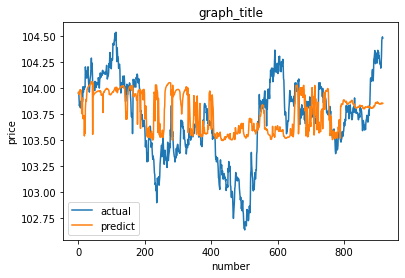

In [97]:
epochs = 15
graph_title = '15h'
y_pred_15h, y_pred = learn(df, X_train, 'y_rate_15h', 'graph_title', epochs, './model/GBPJPY_15h/model.hdf5','./model/GBPJPY_15h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0540 - mae: 0.1871 - val_loss: 0.1545 - val_mae: 0.3787
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0419 - mae: 0.1674 - val_loss: 0.0946 - val_mae: 0.2893
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0432 - mae: 0.1652 - val_loss: 0.1208 - val_mae: 0.3336
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0408 - mae: 0.1618 - val_loss: 0.1039 - val_mae: 0.2755
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

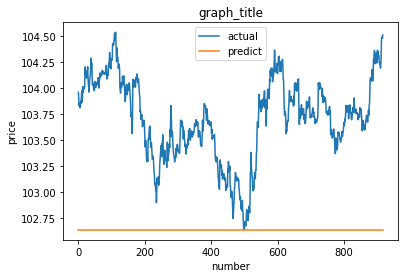

In [98]:
epochs = 15
graph_title = '16h'
y_pred_16h, y_pred = learn(df, X_train, 'y_rate_16h', 'graph_title', epochs, './model/GBPJPY_16h/model.hdf5','./model/GBPJPY_16h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.1545 - mae: 0.3115 - val_loss: 0.1102 - val_mae: 0.3153
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0434 - mae: 0.1665 - val_loss: 0.0749 - val_mae: 0.2560
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0422 - mae: 0.1641 - val_loss: 0.0830 - val_mae: 0.2700
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0405 - mae: 0.1632 - val_loss: 0.1334 - val_mae: 0.3521
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

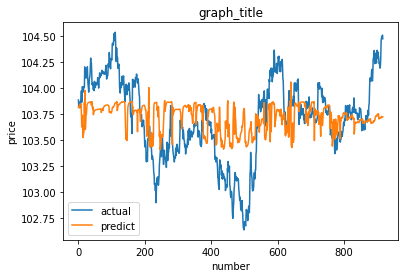

In [118]:
epochs = 15
graph_title = '17h'
y_pred_17h, y_pred = learn(df, X_train, 'y_rate_17h', 'graph_title', epochs, './model/GBPJPY_17h/model.hdf5','./model/GBPJPY_17h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.2283 - mae: 0.3770 - val_loss: 0.1087 - val_mae: 0.3155
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0393 - mae: 0.1574 - val_loss: 0.1662 - val_mae: 0.3976
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0415 - mae: 0.1638 - val_loss: 0.0890 - val_mae: 0.2849
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0423 - mae: 0.1636 - val_loss: 0.0748 - val_mae: 0.2587
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

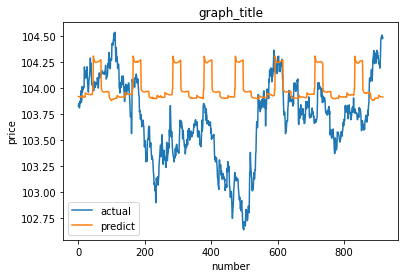

In [100]:
epochs = 15
graph_title = '18h'
y_pred_18h, y_pred = learn(df, X_train, 'y_rate_18h', 'graph_title', epochs, './model/GBPJPY_18h/model.hdf5','./model/GBPJPY_18h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0563 - mae: 0.1896 - val_loss: 0.0219 - val_mae: 0.1329
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0385 - mae: 0.1544 - val_loss: 0.0682 - val_mae: 0.2448
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0441 - mae: 0.1713 - val_loss: 0.0696 - val_mae: 0.2487
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0437 - mae: 0.1663 - val_loss: 0.0923 - val_mae: 0.2905
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

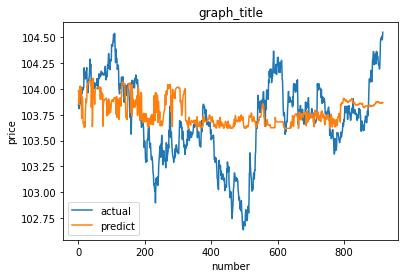

In [129]:
epochs = 15
graph_title = '19h'
y_pred_19h, y_pred = learn(df, X_train, 'y_rate_19h', 'graph_title', epochs, './model/GBPJPY_19h/model.hdf5','./model/GBPJPY_19h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0540 - mae: 0.1793 - val_loss: 0.1225 - val_mae: 0.3403
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0408 - mae: 0.1657 - val_loss: 0.1003 - val_mae: 0.3054
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0406 - mae: 0.1618 - val_loss: 0.0393 - val_mae: 0.1845
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0406 - mae: 0.1511 - val_loss: 0.0753 - val_mae: 0.2674
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

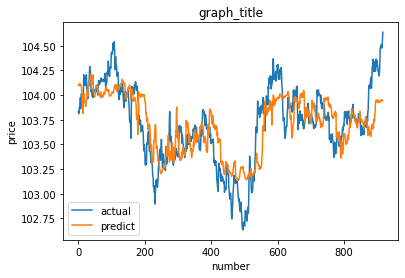

In [130]:
epochs = 15
graph_title = '20h'
y_pred_20h, y_pred = learn(df, X_train, 'y_rate_20h', 'graph_title', epochs, './model/GBPJPY_20h/model.hdf5','./model/GBPJPY_20h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0402 - mae: 0.1643 - val_loss: 0.0687 - val_mae: 0.2512
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0304 - mae: 0.1409 - val_loss: 0.0893 - val_mae: 0.2882
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0314 - mae: 0.1400 - val_loss: 0.0931 - val_mae: 0.2946
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0298 - mae: 0.1376 - val_loss: 0.0934 - val_mae: 0.2957
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

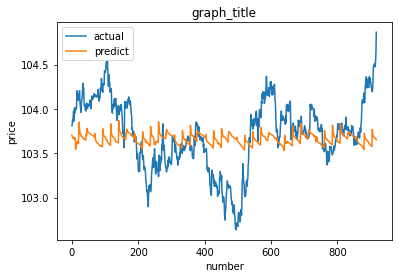

In [131]:
epochs = 15
graph_title = '21h'
y_pred_21h, y_pred = learn(df, X_train, 'y_rate_21h', 'graph_title', epochs, './model/GBPJPY_21h/model.hdf5','./model/GBPJPY_21h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0356 - mae: 0.1519 - val_loss: 0.0914 - val_mae: 0.2935
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0342 - mae: 0.1485 - val_loss: 0.0767 - val_mae: 0.2674
Epoch 3/15
872/872 [==============================] - 2s 3ms/step - loss: 0.0304 - mae: 0.1396 - val_loss: 0.0666 - val_mae: 0.2488
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0302 - mae: 0.1392 - val_loss: 0.1462 - val_mae: 0.3742
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

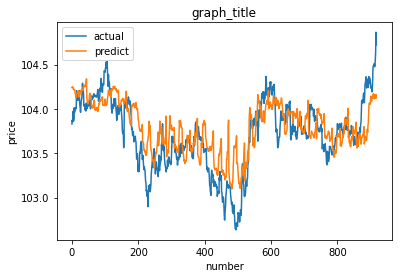

In [132]:
epochs = 15
graph_title = '22h'
y_pred_22h, y_pred = learn(df, X_train, 'y_rate_22h', 'graph_title', epochs, './model/GBPJPY_22h/model.hdf5','./model/GBPJPY_22h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0383 - mae: 0.1570 - val_loss: 0.1151 - val_mae: 0.3302
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0310 - mae: 0.1399 - val_loss: 0.1006 - val_mae: 0.3080
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0323 - mae: 0.1442 - val_loss: 0.1262 - val_mae: 0.3466
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0290 - mae: 0.1360 - val_loss: 0.0832 - val_mae: 0.2787
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

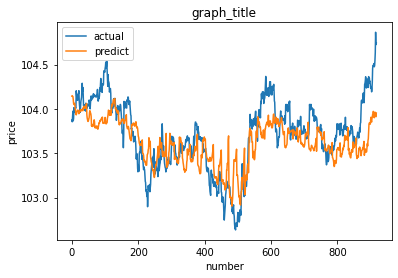

In [133]:
epochs = 15
graph_title = '23h'
y_pred_23h, y_pred = learn(df, X_train, 'y_rate_23h', 'graph_title', epochs, './model/GBPJPY_23h/model.hdf5','./model/GBPJPY_23h/param.hdf5') # 学習関数


入力数: Index(['open', 'high', 'low', 'close', 'Conversion Line', 'Base Line',
       'Lagging Span', 'Lead 1', 'Lead 2', 'Developing Poc',
       'Developing VA High', 'Developing VA Low', 'Volume', 'Volume MA', 'RSI',
       'Plot', 'Plot.1', 'Oscillator', 'ATR', 'time(hour)', 'time(minute)',
       'time(weekday)'],
      dtype='object')
行数: 918
列数: 22
整形前の形状(特徴量): (918, 22)
形状(特徴量): (918, 22, 1)
形状(目的変数): (918, 1)
モデルの学習を開始します
Epoch 1/15
872/872 [==============================] - 3s 2ms/step - loss: 0.0423 - mae: 0.1626 - val_loss: 0.0960 - val_mae: 0.3010
Epoch 2/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0215 - mae: 0.1159 - val_loss: 0.0756 - val_mae: 0.2614
Epoch 3/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0159 - mae: 0.1014 - val_loss: 0.0264 - val_mae: 0.1458
Epoch 4/15
872/872 [==============================] - 2s 2ms/step - loss: 0.0184 - mae: 0.1075 - val_loss: 0.0701 - val_mae: 0.2569
Epoch 5/15
872/872 [====================

<Figure size 432x288 with 0 Axes>

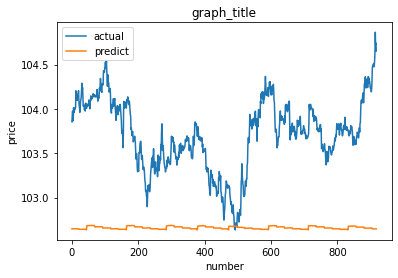

In [141]:
epochs = 15
graph_title = '24h'
y_pred_24h, y_pred = learn(df, X_train, 'y_rate_24h', 'graph_title', epochs, './model/GBPJPY_24h/model.hdf5','./model/GBPJPY_24h/param.hdf5') # 学習関数


[[102.63422442]
 [102.634     ]
 [103.59967212]
 [103.77149859]
 [103.55665824]
 [104.08739307]
 [103.6975537 ]
 [102.634     ]
 [103.85926792]
 [103.68583771]
 [102.634     ]
 [103.70258337]
 [103.67984346]
 [102.634     ]
 [103.85159612]
 [102.634     ]
 [103.72118132]
 [103.91470228]
 [103.86490891]
 [103.94463538]
 [103.66012108]
 [104.12097007]
 [103.91209177]
 [104.07958581]]


<Figure size 432x288 with 0 Axes>

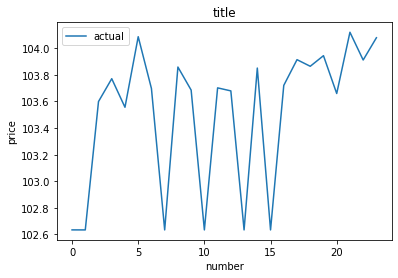

In [135]:
plot_list = np.concatenate([y_pred_1h, y_pred_2h, y_pred_3h, y_pred_4h, y_pred_5h, y_pred_6h, y_pred_7h, y_pred_8h
                           , y_pred_9h, y_pred_10h, y_pred_11h, y_pred_12h, y_pred_13h, y_pred_14h, y_pred_15h, y_pred_16h
                           , y_pred_17h, y_pred_18h, y_pred_19h, y_pred_20h, y_pred_21h, y_pred_22h, y_pred_23h, y_pred_24h])# 5m, 1h, 4h, 8h, 1dの予測リスト

def plot_pred(plot_list):
    flg = plt.figure()
    fig = plt.figure(figsize=(6, 4), dpi=72, linewidth=10)
    ax = fig.add_subplot(111, xlabel='number', ylabel='price',title='title')  # グラフ作成
    
    ax.plot(plot_list, label='actual')  # 5m, 1h, 4h, 8h, 1dの予測リスト
   # ax.plot(y_pred, label='predict')  # 予測
    plt.legend()

plot_pred(plot_list)
print(plot_list)

In [140]:
df['y_rate_24h'].reshape(-1) # Tolistを使う予定

a - y_pred

AttributeError: 'Series' object has no attribute 'reshape'

In [142]:
df['y_rate_24h'] - y_pred

Exception: Data must be 1-dimensional